In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy import signal
import time
import random
import time
import csv

import nidaqmx
from nidaqmx.constants import Edge
from nidaqmx.stream_readers import (
    AnalogSingleChannelReader, AnalogMultiChannelReader)
from nidaqmx.stream_writers import (
    AnalogSingleChannelWriter, AnalogMultiChannelWriter)

In [2]:
class one_freq_result:   #Class to store single frequency response
    def __init__(self,freq_in,amp,rms,rmse,stderr,ps,hs,t,data_to_read,
                 data_to_write,frq,Y,filt_data,Y_f,ps_f,hs_f):
        self.freq_in = freq_in  #input AC frequency
        self.amp = amp; self.rms = rms; self.rmse=rmse; self.stderr=stderr;
        
        self.t = t; self.read = data_to_read; self.wrote = data_to_write; 
        self.filt_data = filt_data;
        self.frqdomain = frq; self.frqresponse = Y  # Frequency domain
        self.filt_frqresponse = Y_f;
        
        self.pfrqs = ps; self.heights = hs
        self.filt_pfrqs = ps_f; self.filt_heights = hs_f
        
        if len(hs)>0 and np.abs(ps-freq_in).min()<0.8:  # Find fft response for freq in
            imain = np.abs(ps-freq_in).argmin()
            self.Vrms = hs[imain]
            self.filt_Vrms = hs[imain]
        else:
            self.Vrms = float('nan')
            self.filt_Vrms = float('nan')
            
        if len(hs)>1 and np.abs(ps-60).min()<0.8:
            i60 = np.abs(ps-60).argmin()
            self.V60 = hs[i60]
            self.filt_V60 = hs[i60]
        else:
            self.V60 = float('nan')
            self.filt_V60 = float('nan')
                   
    def plotFFT(self,a=1,b=100):   
        fig, ax = plt.subplots(2, 1)
        ax[0].plot(self.t,self.read)
        ax[0].set_xlabel('Time')
        ax[0].set_ylabel('Amplitude')
        ax[1].plot(self.frqdomain[a:b],self.frqresponse[a:b],'r')
        ax[1].set_xlabel('Freq (Hz)')
        ax[1].set_ylabel('Vrms|')
        fig.suptitle('{0}hz Input'.format(self.freq_in))
        return fig, ax
    
    def plotFilt(self,a=0,b=100):   
        fig, ax = plt.subplots(2, 1)
        ax[0].plot(self.t,self.filt_data)
        ax[0].set_xlabel('Time')
        ax[0].set_ylabel('Amplitude')
        ax[1].plot(self.frqdomain[a:b],self.filt_frqresponse[a:b],'r')
        ax[1].set_xlabel('Freq (Hz)')
        ax[1].set_ylabel('Vrms|')
        fig.suptitle('{0}hz Input'.format(self.freq_in))
        return fig, ax
        
class many_freqs_result:    # class to store responses from many input frequencies
    def __init__(self,freqs_to_run, amplitudes, rmss, rmses,
                 stderrs, Vrmss, filt_Vrmss, V60, filt_V60, abc):
        self.freqs = freqs_to_run; self.amps = amplitudes; self.rmss = rmss
        self.rmses = rmses; self.stderrs = stderrs; self.Vrmss = Vrmss
        self.filt_Vrmss = filt_Vrmss; self.V60 = V60; self.filt_V60 = filt_V60
        self.freq_results = abc
        
    def oneFreq(self,fn,a=1,b=100):
        fn = fn - 1  # meant to pass in number of freq wanted
        self.freq_results[fn].plotFFT(a,b)
        
    def plotFFTs(self):
        for r in self.freq_results:
            plt.plot(r.frqdomain,r.frqresponse,label=r.freq_in)
            
        plt.xlabel('Frequency'); plt.ylabel('V'); plt.xscale('log') 
        plt.ylim(0,1.5*np.max(self.Vrmss))
    
    def plotRaw(self):
        for r in self.freq_results:
            plt.plot(r.t,r.wrote,r.t,r.read)
        plt.xlabel('Time (seconds)'); plt.ylabel('V')
    
    def plotVrms(self):
        plt.plot(self.freqs,self.Vrmss,'.',self.freqs,self.V60,'.')
        plt.xscale('log'); plt.grid(True); plt.legend(['Vrms','V60'])
        plt.xlabel('Frequency'); plt.ylabel('Vrms')
        
    def plotFiltVrms(self):
        plt.plot(self.freqs,self.filt_Vrmss,'.',self.freqs,self.filt_V60,'.')
        plt.xscale('log'); plt.grid(True); plt.legend(['Filtered_Vrms','Filtered_V60'])
        plt.xlabel('Frequency'); plt.ylabel('Vrms')
        
    def plotErr(self):
        plt.errorbar(self.freqs,self.Vrmss,yerr=self.stderrs)
        plt.xscale('log'); plt.xlabel('Frequency'); plt.ylabel('Vrms')
  

In [3]:
def filterSig(fs,data, f0 = 60.0,Q = .5,):
    w0 = f0/(fs/2)  # Normalized Frequency

    b, a = signal.iirnotch(w0, Q) # Design notch filter
    sigFilt = signal.lfilter(b,a,data) # Use filter on data
    
    return sigFilt

def ReadOneFreq(freq_in,duration):
    
    s_per_cyc = 400
    
    if freq_in*s_per_cyc < 10e6:  #calc samp rate from points per cycle
        samp_rate = freq_in*s_per_cyc 
    else:
        samp_rate = 10000000

    n_points = int(duration*samp_rate)  # total points to read and write

    t = np.linspace(0,duration,n_points)  # time vector

    data_to_write = np.sin((freq_in*2*np.pi)*t)  # signal vector  
    data_to_read = np.zeros(n_points,dtype=float) # pickup signal empty array

    with nidaqmx.Task() as write_task, nidaqmx.Task() as read_task, \
                    nidaqmx.Task() as sample_clk_task:
        # Use a counter output pulse train task as the sample clock source
        # for both the AI and AO tasks.
        sample_clk_task.co_channels.add_co_pulse_chan_freq(
            '{0}/ctr0'.format('Dev1'), freq=samp_rate)
        sample_clk_task.timing.cfg_implicit_timing(
            samps_per_chan=n_points)

        samp_clk_terminal = '/{0}/Ctr0InternalOutput'.format(
            'Dev1')
        
        # Write on the rising edge
        write_task.ao_channels.add_ao_voltage_chan('Dev1/ao0')
        write_task.timing.cfg_samp_clk_timing(
            samp_rate, source=samp_clk_terminal, active_edge=Edge.RISING,
            samps_per_chan=n_points) 
        
        # Read on the falling edge
        read_task.ai_channels.add_ai_voltage_chan('Dev1/ai0')
        read_task.timing.cfg_samp_clk_timing(
            samp_rate, source=samp_clk_terminal,
            active_edge=Edge.FALLING, samps_per_chan=n_points)

        writer = AnalogSingleChannelWriter(write_task.out_stream)
        reader = AnalogSingleChannelReader(read_task.in_stream)

        n_written = writer.write_many_sample(data_to_write)

        read_task.start()
        write_task.start()
        sample_clk_task.start()

        n_read = reader.read_many_sample(data_to_read,
                                         number_of_samples_per_channel=
                                         n_points,timeout=int(duration+1))
 
    # filter signal
    filt_data = filterSig(samp_rate,data_to_read) 
    
    # Basic stats: amplitude, rms, rmse, standard error
    peaks, pros = signal.find_peaks(data_to_read,height = 0.2, 
                                distance = int(s_per_cyc/2))    
    heights = pros['peak_heights']
    if len(heights)>0:
        amplitude = np.mean(heights)
        rms = np.sqrt(np.mean(heights**2))
        rmse = np.sqrt(np.mean((data_to_read-data_to_write)**2))
        stderr = np.std(heights)
    else:
        amplitude = float('nan'); rms = float('nan'); rmse = float('nan')
        stderr = float('nan')
    
    # fft:
    n = len(data_to_read) # length of the signal
    k = np.arange(n); 
    T = n/samp_rate
    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range

    Y = np.fft.fft(data_to_read)/n # fft computing and normalizing
    Y_f = np.fft.fft(filt_data)/n  # fft of filtered signal
    Y = 2*abs(Y[range(int(n/2))]) # one side fft, so x2
    Y_f = 2*abs(Y_f[range(int(n/2))]) # onse side filtered data
    
    # Get fft data
    peak_inds, props = signal.find_peaks(Y,height=0.001) # get peaks' inds
    hs = props['peak_heights']  #retrieve peak heights
    ps = frq[peak_inds] # replace frequency indices with freq values
    
    # Get fft filtered data
    peak_inds_f, props_f = signal.find_peaks(Y_f,height=0.001) # get peaks' inds
    hs_f = props_f['peak_heights']
    ps_f = frq[peak_inds_f] # replace frequency indices with freq values

    #results = {'amp':amplitude,'rms':rms,'rmse':rmse,}
    r = one_freq_result(freq_in,amplitude,rms,rmse,stderr,ps,hs,t,
                     data_to_read,data_to_write,frq,Y,filt_data,Y_f,ps_f,hs_f)
    return r
    
def RunSweep(start_freq = 100, stop_freq = 2000, n_freqs_2_hit = 40,
             cycs_at_freq = 10):

    freqs_to_run = np.around(np.logspace(np.log10(start_freq),
                               np.log10(stop_freq),n_freqs_2_hit),2)
    amplitudes = np.empty_like(freqs_to_run,dtype=float)
    rmss = np.empty_like(amplitudes); rmses = np.empty_like(amplitudes)
    Vrmss = np.empty_like(amplitudes); V60 = np.empty_like(amplitudes)
    filt_Vrmss = np.empty_like(amplitudes); filt_V60 = np.empty_like(amplitudes)
    stderrs = np.empty_like(amplitudes)

    abc = []
    i=0; print('Freqs running: ', end='',flush=True)
    for freq in freqs_to_run:
        print(freq,'...',end='',flush=True)
        print('.',end='',flush=True)
        dur = cycs_at_freq/freq
        r = ReadOneFreq(freq,dur)
        abc.append(r)
        amplitudes[i] = r.amp; rmss[i]= r.rms
        rmses[i]=r.rmse
        stderrs[i]=r.stderr
        Vrmss[i] = r.Vrms; filt_Vrmss[i]=r.filt_Vrms
        V60[i] = r.V60; filt_V60[i]=r.filt_V60
        i=i+1; time.sleep(0.1) #Wait between runs to settle EMF
        
    rs = many_freqs_result(freqs_to_run, amplitudes, rmss,
                           rmses, stderrs, Vrmss, filt_Vrmss, V60, filt_V60, abc)
    print('Done', end='',flush=True)    
    return rs

In [4]:
rs = RunSweep(start_freq = 100, stop_freq = 2000,
              n_freqs_2_hit = 10,cycs_at_freq = 20)

Freqs running: 100.0 ....139.5 ....194.59 ....271.44 ....378.65 ....528.2 ....736.81 ....1027.81 ....1433.74 ....2000.0 ....Done

(<Figure size 432x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002426BB7D2B0>,
       dtype=object))

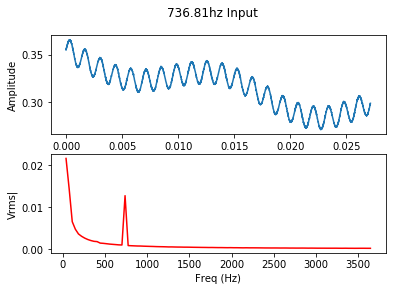

In [14]:
b = rs.freq_results[6]
b.plotFFT()

Freqs running: 200.0 ....278.99 ....389.18 ....542.88 ....757.3 ....1056.39 ....1473.61 ....2055.62 ....2867.48 ....4000.0 ....DoneFreqs running: 200.0 ....278.99 ....389.18 ....542.88 ....757.3 ....1056.39 ....1473.61 ....2055.62 ....2867.48 ....4000.0 ....DoneFreqs running: 200.0 ....278.99 ....389.18 ....542.88 ....757.3 ....1056.39 ....1473.61 ....2055.62 ....2867.48 ....4000.0 ....DoneFreqs running: 200.0 ....278.99 ....389.18 ....542.88 ....757.3 ....1056.39 ....1473.61 ....2055.62 ....2867.48 ....4000.0 ....Done

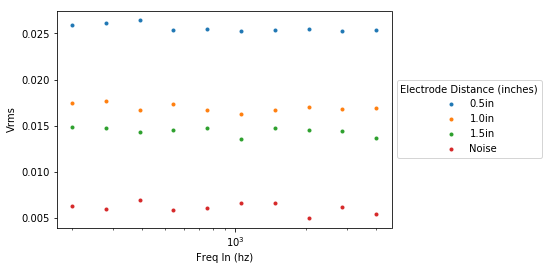

fin


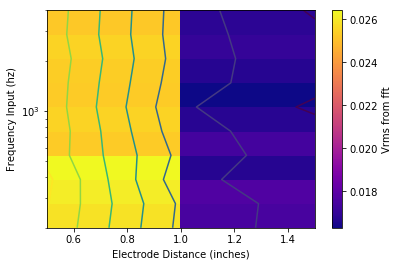

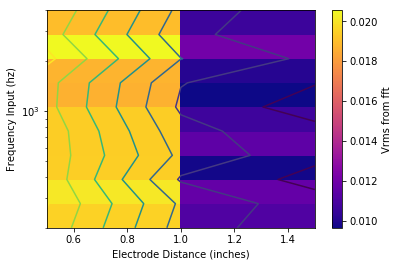

In [15]:
distances = np.arange(0.5,2,0.5)  # Fill Distances

start_freq = 200; stop_freq = 4000  # Fill Frequencies
n_freqs_2_hit = 10; cycs_at_freq = 10

# Go
runs = []

input('Base Noise: Short Leads, \
Leave 1 lead out of sand, then press Enter to run sweep')

noise = RunSweep(start_freq = start_freq, stop_freq = stop_freq,
              n_freqs_2_hit = n_freqs_2_hit,cycs_at_freq = cycs_at_freq)

i = 0
d = len(distances)
X = distances
Y = noise.freqs
Z = np.zeros((d,len(noise.freqs)))

f1, ax1 = plt.subplots()

for d in distances:
    input('Touch leads to short. Move lead to {0}in, then press Enter to run sweep'.format(d))
    run = RunSweep(start_freq = start_freq, stop_freq = stop_freq,
              n_freqs_2_hit = n_freqs_2_hit,cycs_at_freq = cycs_at_freq)
    runs.append(run)
    ax1.plot(run.freqs,run.Vrmss,'.', label = '{0}in'.format(d))
    Z[i,:] = run.Vrmss; i = i+1

ax1.plot(noise.freqs,noise.Vrmss,'.', label = 'Noise')
ax1.set_xlabel('Freq In (hz)'); ax1.set_ylabel('Vrms')
ax1.set_xscale('log'); ax1.legend(title= 'Electrode Distance (inches)',loc='center left', bbox_to_anchor=(1, 0.5)); plt.show()

f2, ax2 = plt.subplots()

cax = ax2.pcolormesh(X,Y,Z.T, cmap='plasma')
conax = ax2.contour(X,Y,Z.T); ax2.set_yscale('log')
ax2.set_ylabel('Frequency Input (hz)'); ax2.set_xlabel('Electrode Distance (inches)')
cbar = f2.colorbar(cax); cbar.set_label('Vrms from fft')

noiseV = np.tile(noise.Vrmss,(Z.shape[0],1))
Z_nan = Z - noiseV; Z_nan[Z_nan<0] = float('nan')

f3, ax3 = plt.subplots()

caxn = ax3.pcolormesh(X,Y,Z_nan.T, cmap='plasma')
conaxn = ax3.contour(X,Y,Z_nan.T); ax3.set_yscale('log')
ax3.set_ylabel('Frequency Input (hz)'); ax3.set_xlabel('Electrode Distance (inches)')
cbar = f3.colorbar(caxn); cbar.set_label('Vrms from fft')

f1.savefig('p1')
f2.savefig('p2')
f3.savefig('p2_without_noise')

outvar = {'dist':X,'freqs':Y,'vrms':Z}

for word in outvar:
    np.savetxt('{0}.txt'.format(word), outvar[word],delimiter=',')

print('fin')